In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from spring_embedding_models import SequentialHierarchyCommunitySimple, SequentialHierarchyCommunityMulti

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_labeled_network_and_get_largest_wcc(edge_file, node_file):
    # Step 1: Read node labels
    with open(node_file, 'r') as f:
        node_labels = set(line.strip().split(',')[0] for line in f if line.strip())

    # Step 2: Read edge list with labels directly
    G = nx.read_edgelist(edge_file, create_using=nx.DiGraph(), nodetype=str, delimiter=',')
    G = G.reverse(copy=True)

    # Step 3: Filter to only valid nodes from node list
    G = G.subgraph([n for n in G.nodes if n in node_labels]).copy()

    # Step 4: Get largest weakly connected component
    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [3]:
G_wcc = load_labeled_network_and_get_largest_wcc('data/1998_fall_edge_list.csv', 'data/1998_fall_node_list.csv')
node_list = list(G_wcc.nodes)
A_wcc = nx.to_numpy_array(G_wcc, nodelist=node_list)

100%|██████████| 300/300 [01:59<00:00,  2.50it/s]


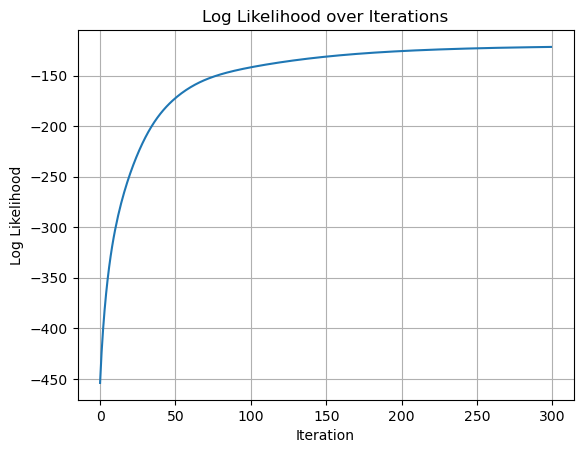

In [11]:
simple_model = SequentialHierarchyCommunitySimple(adj_matrix=A_wcc, embedding_dim=4, k=5, beta=1)
_ = simple_model.fit()

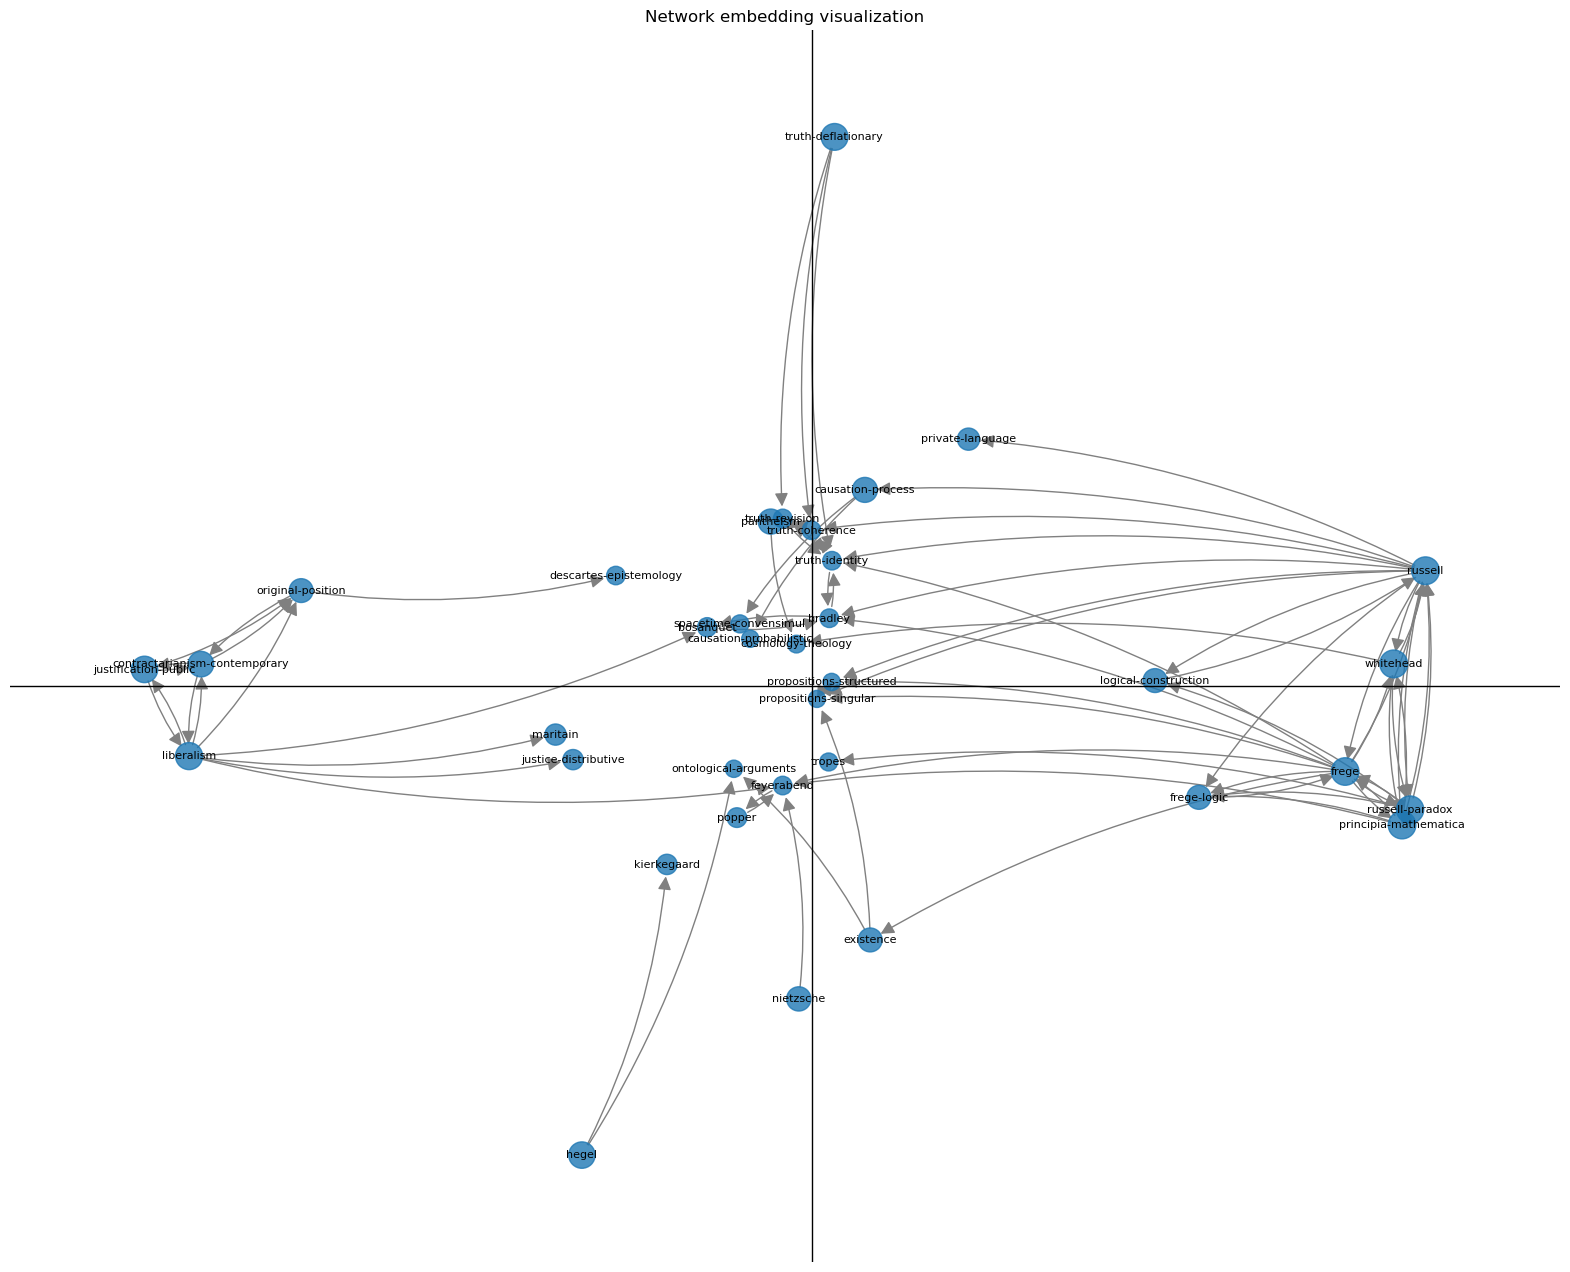

In [19]:
simple_model.visualize(node_labels=node_list)

In [4]:
parakeets = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
parakeets.head()

,group,study.quarter,actor,target,number.wins
0,G1,1,bbb,rgn,1
1,G1,1,bgn,bng,2
2,G1,1,bgn,ggg,4
3,G1,1,bgn,grr,1
4,G1,1,bgn,nrb,3


In [ ]:
def get_parakeet_data(group="g1"):

    df = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
    df = df[df["group"] == group.upper()]

    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['actor'], row['target'])

    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [25]:
G_parakeet_g1 = get_parakeet_data("g1")
A_parakeet_g1 = nx.to_numpy_array(G_parakeet_g1, nodelist=G_parakeet_g1.nodes)

100%|██████████| 500/500 [00:28<00:00, 17.53it/s]


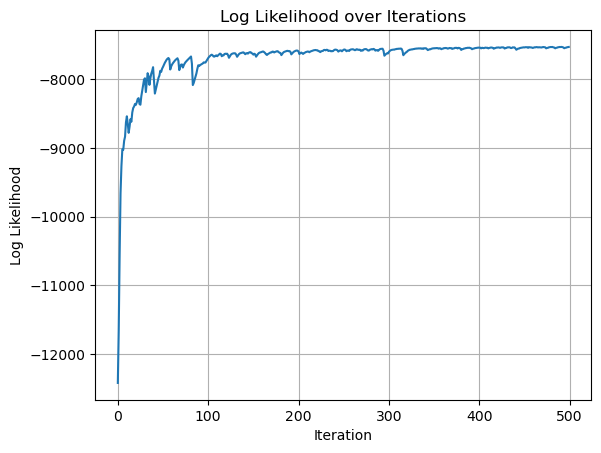

In [ ]:
g1_model = SequentialHierarchyCommunityMulti(adj_matrix=A_parakeet_g1, embedding_dim=2, k=3, beta=1)
_ = g1_model.fit(max_iter=500)

Text(0.5, 1.0, 'Parakeet G1 node embedding norms')

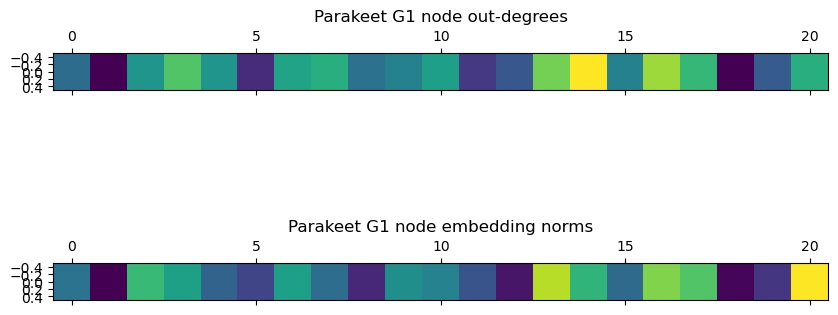

In [37]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))

ax[0].matshow([A_parakeet_g1.sum(axis=1)])
ax[0].set_title("Parakeet G1 node out-degrees")

ax[1].matshow([np.linalg.norm(g1_model.embeddings, axis=1)])
ax[1].set_title("Parakeet G1 node embedding norms")

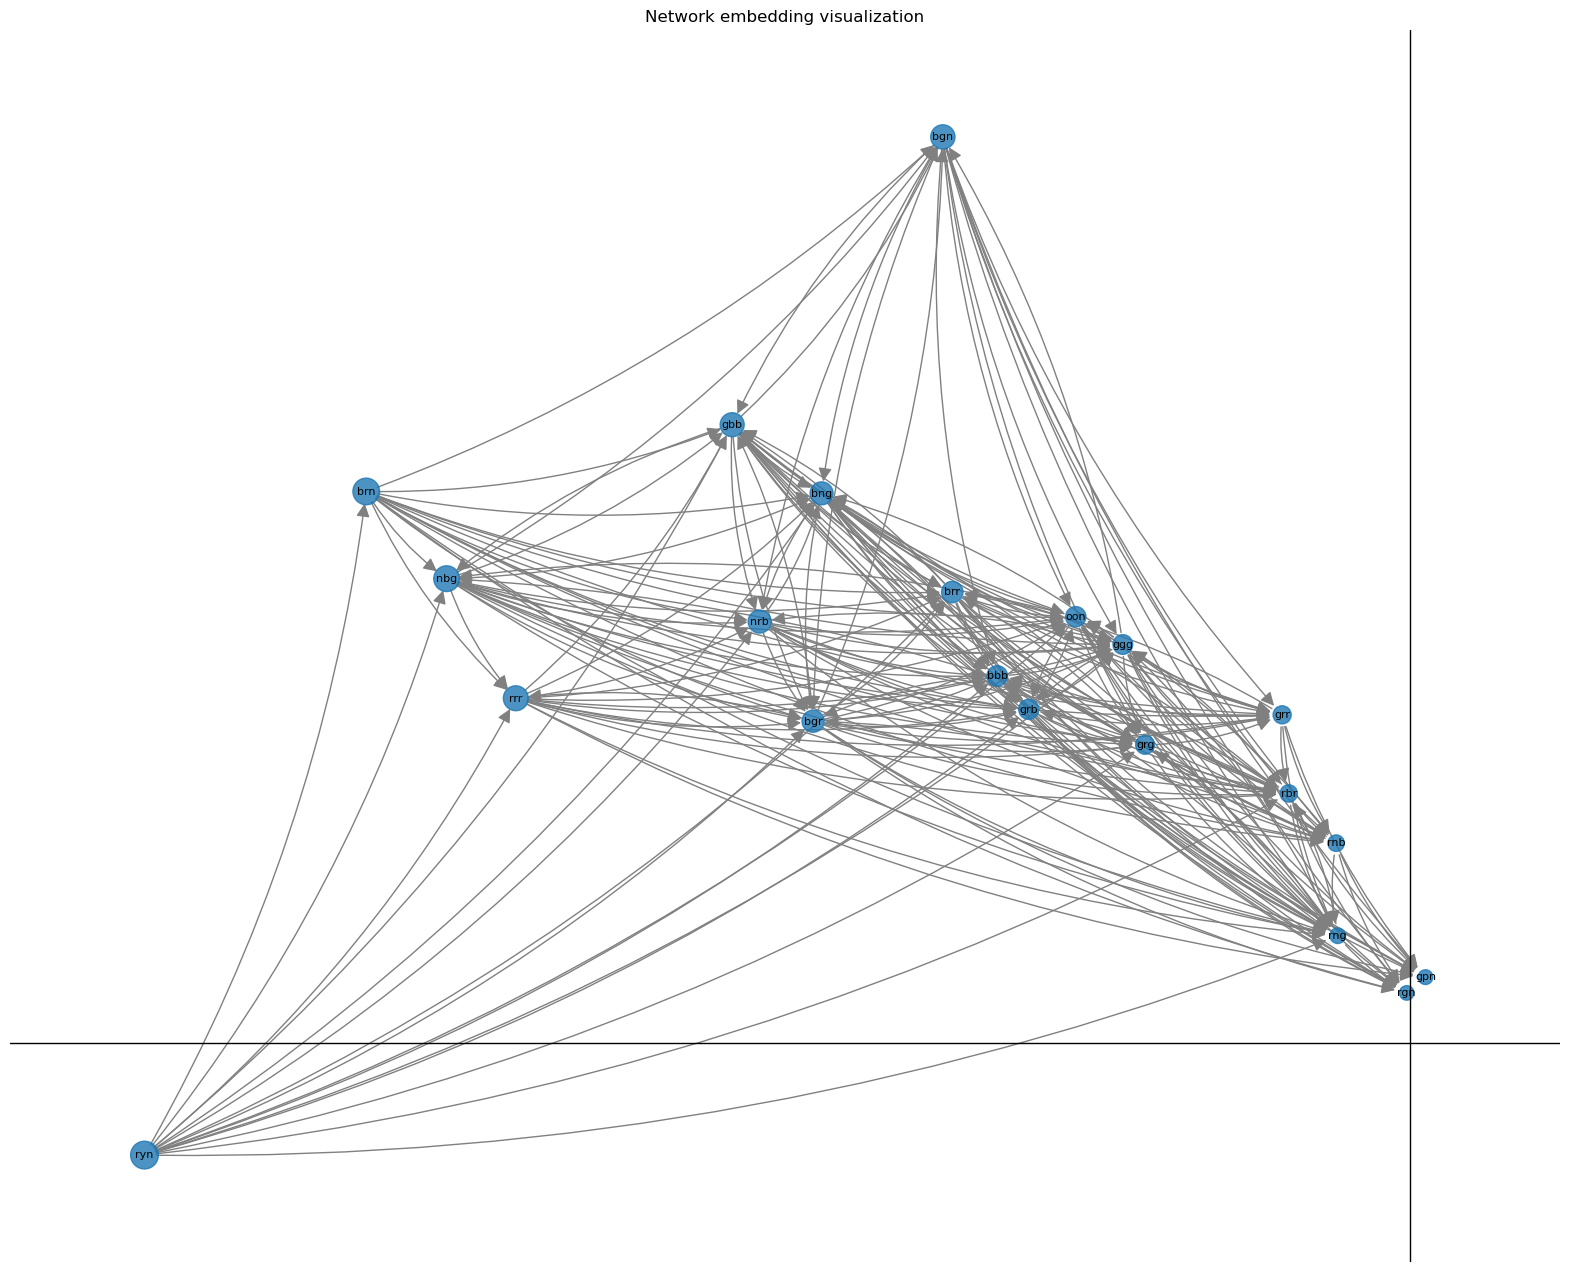

In [22]:
g1_model.visualize(node_labels=list(G_parakeet_g1.nodes))